<a href="https://colab.research.google.com/github/hossein20s/random-forest-timeseries/blob/master/stupid_randforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Looking in to random forest for light curve modeling

Do the stupidest thing possible first:
- read in Kepler 17 light curve 
- down-sample light curve to 2-hour samples (simple interpolation)
- bin the light curve up in to 20 day bins, slide each subsequent bin by 5 days
- each bin is one *instance*
- within each bin, the features are delta time and delta flux from the last data point

In [6]:
REPO_NAME= 'random-forest-timeseries'
from google.colab import drive
drive.mount('/content/drive')
%run /content/drive/My\ Drive/lib/InitLib.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/gdrive
Vesion:1.2
mkdir: cannot create directory ‘/content/gdrive/My Drive/src/’: File exists
Cloning into 'random-forest-timeseries'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Unpacking objects: 100% (11/11), done.


In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
%pylab inline
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR


Populating the interactive namespace from numpy and matplotlib


In [10]:
#rawdata = pd.read_table('kepler17_whole.dat', delim_whitespace=True, 
#                        header=0, names=('time','flux','error'))
#rawdata.tail(5)


#time_raw,flux_raw,err_raw = np.loadtxt('kepler17_whole.dat',unpack=True)
#time_raw

time0,flux,err = np.loadtxt(REPO_DIR + '/kepler17_downsample2.dat',unpack=True)

# Let's just use time before day=600 to avoid big data gap
flux = flux[(time0 < 600)]
time = time0[(time0 < 600)]

print(np.shape(time), np.shape(flux))

(2343,) (2343,)


(200, 290)

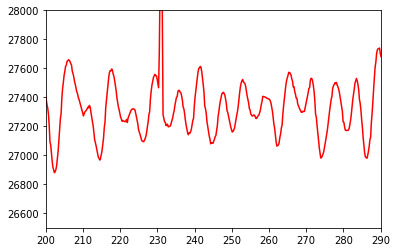

In [11]:

plt.plot(time,flux,'r-')
plt.ylim((2.65e4,2.8e4))
plt.xlim((200,290))

---
## Do a loop over dataframe to make instances

create 20-day bins, separated by 1-day, compute features (delta time, delta flux)

In [12]:
# FEATURES dimensions: 2(time,flux) x N(pts in window) x N_windows
# LABELS dimensions: N_windows

Npts = 100 # data points within each window
Nwnd = len(time)-2*Npts-1 # move each window by 1 data point, keep last chunk for prediction

# Features should have dimensions (N_instances x N_features)
# Labels should have dimensions (N_instances)
feat = np.zeros( [Nwnd, Npts] ) - 9999999. # blank array to fill
labl = np.zeros( [Nwnd] ) - 99999.
sh = np.shape(feat)

print('shape of feature array:',sh)
print(Nwnd)


# Now fill the feature and label arrays
for i in range(int(Nwnd)):
    #feat[i,:] = np.concatenate((time[i:i+Npts] - time[i+Npts], 
    #                            flux[i:i+Npts] - flux[i+Npts]))
    feat[i,:] = flux[i:i+Npts] - flux[i+Npts]
    labl[i] = flux[i+Npts+1] - flux[i+Npts]


shape of feature array: (2142, 100)
2142


In [13]:

# Now make test features and test labels to compare with
test_feat = np.zeros( [Npts, Npts] )
test_labl = np.zeros( [Npts] )

print(np.size(test_feat),np.size(test_labl))

for i in range(Npts):
    #test_feat[i,:] = np.concatenate((time[i+Nwnd:i+Nwnd+Npts] - time[i+Nwnd+Npts],
    #                                 flux[i+Nwnd:i+Nwnd+Npts] - flux[i+Nwnd+Npts]))
    test_feat[i,:] = flux[i+Nwnd:i+Nwnd+Npts] - flux[i+Nwnd+Npts]
    test_labl[i] = flux[i+Nwnd+Npts+1] - flux[i+Nwnd+Npts]
    

10000 100


In [15]:
# Code taken from Josh Bloom's lecture

from sklearn.ensemble import RandomForestRegressor
clf2 = RandomForestRegressor(n_estimators=1000, 
                            criterion='mse')
clf2.fit(feat, labl)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

100


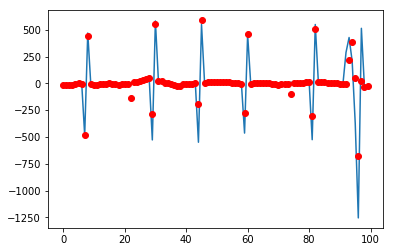

In [17]:
pred = clf2.predict(test_feat)
print(len(pred))

# try plotting the actual delta fluxes vs the predicted
plt.plot(test_labl)
plt.plot(pred,'ro')

# New SectionTrting to measure the error (AUC or SME)

In [51]:
%run gdrive/My\ Drive/lib/graphlib.ipynb

Version 1.9


In [52]:
calculate_errors(test_labl, pred)

explained_variance_score 0.7541311184944863
mean_absolute_error 41.539658149219946
mean_squared_error 12357.834670048936
median_absolute_error 6.915623045799991


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  if sys.path[0] == '':


(50, 70)

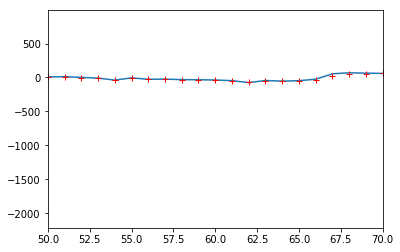

In [18]:
# now let's draw the predictions for the entire training dataset... stupid to do?

pred_big = clf2.predict(feat)
plt.plot(labl)
plt.plot(pred_big, 'r+')
plt.xlim((50,70))

In [19]:
zip(clf2.feature_importances_)

Text(0, 0.5, 'Importance')

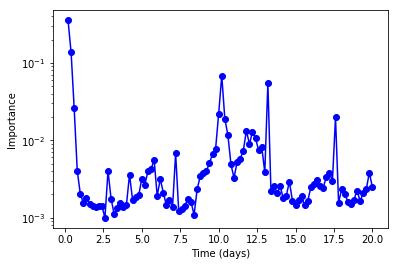

In [53]:
plt.semilogy(time[Npts]-time[0:Npts], clf2.feature_importances_,'bo-')
plt.xlabel('Time (days)');  plt.ylabel('Importance')

## Test Support Vector Regression

In [54]:
XX = np.transpose(np.array([time]))
YY = flux
print(np.shape(XX))

(2343, 1)


In [0]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(XX, YY).predict(XX)

(200, 300)

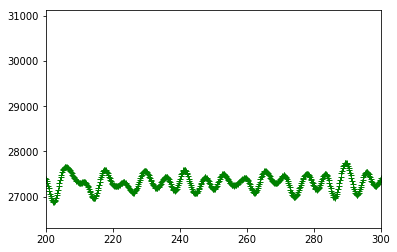

In [22]:
plt.plot(XX, y_rbf, 'g+')
plt.xlim((200,300))
#plt.ylim((-500,500))